In [18]:
# Usual imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (18, 10)

# OpenCV
import cv2

# Keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Cleverhans
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

# Other modules
from pathlib import Path
from glob import glob
from tqdm.notebook import tqdm

Similar to what we did in Project 1, we will now define some constant for the path to annotations and images

In [5]:
DATA_FOLDER = Path('../data')
IMG_FOLDER = Path(DATA_FOLDER / 'tsrd-train')
ANNOTATIONS = Path(DATA_FOLDER / 'TsignRecgTrain4170Annotation.txt')
COL_NAMES = ['filename','width','height','x1','y1','x2','y2','label']
MODEL_FOLDER = Path('../Part_1')
MODEL = Path(MODEL_FOLDER / 'chinese_traffic_sign_classifier_v1.h5')

In [6]:
df = pd.read_csv(ANNOTATIONS, names=COL_NAMES, sep=';', header=None, index_col=False)
classifier = load_model(MODEL)

In order to create the adversarial examples, we will first import all the images. We use the same function calls from Project 1:

In [7]:
images = glob(str(IMG_FOLDER) + '/*.png')
IMG_SIZE = (134,128)

dataset = []
labels = []

for idx in range(len(images)):
    full_img_path = images[idx]
    filename = Path(full_img_path).name
    img_bgr = cv2.imread(full_img_path)
    image = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMG_SIZE)
    image = img_to_array(image)
    dataset.append(image)
    # get label specific to this image
    row = df[df['filename'] == filename]
    label = row['label'].values[0]
    if row.empty:
        print(filename)
    else:
        labels.append(label)

dataset = np.array(dataset) / 255.0
labels = to_categorical(labels)

(train_X, valid_X, train_Y, valid_Y) = train_test_split(dataset, labels,
                                                        test_size=0.2, stratify=labels)

Let's check the accuracy of the model on the validation set we just created

In [8]:
pred_base = classifier.predict(valid_X)
acc_base = np.sum(np.argmax(pred_base, axis=1) == np.argmax(valid_Y, axis=1)) / len(valid_Y)
print(f"Accuracy on validation dataset: {acc_base * 100:.2f}%")

Accuracy on validation dataset: 98.68%


Now, similar to what we did in Project 2, we will create adversarial examples using the FGSM method. In this case, though, we will be using the Cleverhans implementation of the algorithm instead of that of ART. We will also create adversarial examples by adding random uniform noise to our images.

In [9]:
EPSILON_FGSM = 0.08
EPSILON_NOISE = 0.03

num_samples = 500 # as suggested in the hints

# Select num_samples random entries from the validation set
idx = np.random.randint(0, valid_X.shape[0], num_samples)
valid_X_fgsm = fast_gradient_method(classifier, valid_X[idx, :], EPSILON_FGSM, np.inf)
valid_Y_fgsm = valid_Y[idx]

Let's compute the predictions of the classifier on the adversarial examples and calculate the accuracy on them.

In [10]:
pred_fgsm = classifier.predict(valid_X_fgsm)
acc_fgsm = np.sum(np.argmax(pred_fgsm, axis=1) == np.argmax(valid_Y_fgsm, axis=1)) / len(valid_Y_fgsm)
print(f"Accuracy on fgsm-corrupted dataset: {acc_fgsm * 100:.2f}%")

Accuracy on fgsm-corrupted dataset: 19.00%


Now let's do the same adding uniform noise to the images

In [14]:
valid_X_noise = valid_X[idx, :] + np.random.uniform(low=-EPSILON_NOISE, high=EPSILON_NOISE,
                                                    size=valid_X[idx, :].shape)
valid_Y_noise = valid_Y_fgsm
pred_noise = classifier.predict(valid_X_noise)
acc_noise = np.sum(np.argmax(pred_noise, axis=1) == np.argmax(valid_Y_noise, axis=1)) / len(valid_Y_noise)
print(f"Accuracy on noise-corrupted dataset: {acc_noise * 100:.2f}%")

Accuracy on noise-corrupted dataset: 99.20%


Ok, surprisingly adding noise INCREASED the accuracy! But the point here is to show that it's not enough to add noise to the image, we have to do so in a sensible way if we want to create an adversarial example.

Now, let's make our classifier robust to the FGSM attack. We will do so by training our current classifier with the images from the dataset AND the adversarial images we will create in each training step.

In [21]:
# Using the same values as in the hints
NUM_OF_RETRAIN_ITER = 3

es = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, verbose=1, restore_best_weights=True,
                   mode='min')


for i in tqdm(range(NUM_OF_RETRAIN_ITER)):
    idx = np.random.randint(0, train_X.shape[0], num_samples)
    X_fgsm = fast_gradient_method(classifier, train_X[idx, :], EPSILON_FGSM, np.inf)
    Y_fgsm = train_Y[idx]
    
    train_X_tmp = np.concatenate((train_X, X_fgsm), axis=0)
    train_Y_tmp = np.concatenate((train_Y, Y_fgsm), axis=0)
    
    classifier.fit(train_X_tmp, train_Y_tmp, epochs=100, verbose=0, callbacks=[es],
              validation_data=(X_fgsm, Y_fgsm), batch_size=1000)
    
classifier.save('../robust_chinese_traffic_sign_classifier.h5')

  0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

Ok, we can now check how the model performs on adversarial images after the training step.

In [22]:
idx = np.random.randint(0, valid_X.shape[0], num_samples)
valid_X_fgsm = fast_gradient_method(classifier, valid_X[idx, :], EPSILON_FGSM, np.inf)
valid_Y_fgsm = valid_Y[idx]
pred_fgsm = classifier.predict(valid_X_fgsm)
acc_fgsm = np.sum(np.argmax(pred_fgsm, axis=1) == np.argmax(valid_Y_fgsm, axis=1)) / len(valid_Y_fgsm)
print(f"Accuracy on fgsm-corrupted dataset: {acc_fgsm * 100:.2f}%")

Accuracy on fgsm-corrupted dataset: 10.20%


Finally, we plot the images of the original dataset and the ones corrupted with noise and the fgsm method, as well as the prediction from the classifier

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


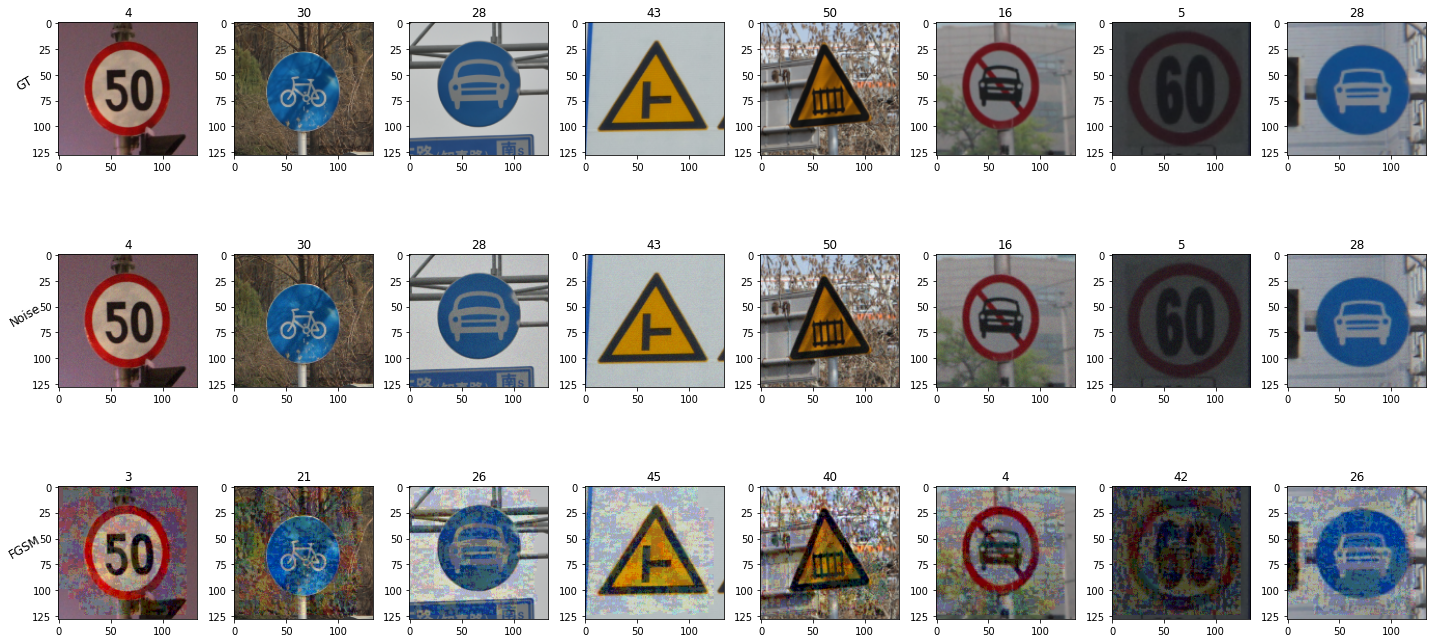

In [24]:
ROWS = 3
COLS = 8
fig, axes = plt.subplots(ROWS, COLS, figsize=(20, 10))

row_labels = ['GT', 'Noise', 'FGSM']

idx = np.random.randint(0, valid_X.shape[0], COLS)
valid_X_subset = valid_X[idx, :]
valid_X_fgsm = fast_gradient_method(classifier, valid_X_subset, EPSILON_FGSM, np.inf)
valid_X_noise = valid_X_subset + np.random.uniform(low=-EPSILON_NOISE, high=EPSILON_NOISE,
                                                    size=valid_X_subset.shape)

pred_base = classifier.predict(valid_X_subset)
pred_fgsm = classifier.predict(valid_X_fgsm)
pred_noise = classifier.predict(valid_X_noise)

for k in range(COLS):
    axes[0,k].imshow(valid_X_subset[k])
    axes[1,k].imshow(valid_X_noise[k].clip(0.0,1.0)) #.clip(0.0,1.0)
    axes[2,k].imshow(valid_X_fgsm[k])
    
    axes[0,k].set_title(str(pred_base[k].argmax()))
    axes[1,k].set_title(str(pred_noise[k].argmax()))
    axes[2,k].set_title(str(pred_fgsm[k].argmax()))
    
for ax, row in zip(axes[:,0], row_labels):
    ax.set_ylabel(row, rotation=30, size='large')

fig.tight_layout()
plt.show()